#### Kaggle Dataset

 "https://www.kaggle.com/datasets/danofer/compass/data"

### Tools

This notebook is self-contained, but it requires some python libraries. To install them, simply run the following line:

In [ ]:
# Install a pip package in the current Jupyter kernel.
import sys
import site
import os
#usersite = site.getusersitepackages()
#if usersite not in sys.path:
#    sys.path.append(usersite)
#!{sys.executable} -m pip install --user -r requirements.txt

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.1 MB/s eta 0:00:00


# Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import gc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
sns.set_theme(color_codes=True)
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings(action='ignore')

# Feature pre-proccessing

In [ ]:
df = pd.read_csv('cox-violent-parsed.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


### Explainability

Dictionary of variables

### Robustness

Feature engineering:

- Data preparation and Data cleaning

In [ ]:
# We code the gender by 1 Male 0 Female
df["sex"].replace({'Male': 1, 'Female': 0}, inplace=True)

In [ ]:
# remove unneeded column identifiers
df.drop(columns = ['last','first','out_custody','in_custody','c_offense_date','decile_score.1','priors_count.1','c_case_number','days_b_screening_arrest','start','end','event','screening_date','c_case_number','juv_other_count','juv_misd_count','juv_fel_count','r_days_from_arrest','id','r_charge_degree','r_offense_date', 'vr_case_number','r_case_number','r_jail_out','c_arrest_date','r_charge_desc','r_jail_in', 'violent_recid','vr_charge_degree','vr_offense_date','vr_charge_desc'], inplace=True)
df.head()

,name,compas_screening_date,sex,dob,age,age_cat,race,decile_score,priors_count,c_jail_in,c_jail_out,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,is_violent_recid,type_of_assessment,score_text,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date
0,miguel hernandez,14/08/2013,1,18/04/1947,69,Greater than 45,Other,1,0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14/08/2013
1,miguel hernandez,14/08/2013,1,18/04/1947,69,Greater than 45,Other,1,0,13/08/2013 6:03,14/08/2013 5:41,1.0,(F3),Aggravated Assault w/Firearm,0,0,Risk of Recidivism,Low,Risk of Violence,1,Low,14/08/2013
2,michael ryan,31/12/2014,1,06/02/1985,31,25 - 45,Caucasian,5,0,NaN,NaN,NaN,NaN,NaN,-1,0,Risk of Recidivism,Medium,Risk of Violence,2,Low,31/12/2014
3,kevon dixon,27/01/2013,1,22/01/1982,34,25 - 45,African-American,3,0,26/01/2013 3:45,05/02/2013 5:36,1.0,(F3),Felony Battery w/Prior Convict,1,1,Risk of Recidivism,Low,Risk of Violence,1,Low,27/01/2013
4,ed philo,14/04/2013,1,14/05/1991,24,Less than 25,African-American,4,4,13/04/2013 4:58,14/04/2013 7:02,1.0,(F3),Possession of Cocaine,1,0,Risk of Recidivism,Low,Risk of Violence,3,Low,14/04/2013


In [ ]:
#We need to convert variables to date and count days in prison.
df['c_jail_in'] = pd.to_datetime(df['c_jail_in'])
df['c_jail_out'] = pd.to_datetime(df['c_jail_out'])
df['days_in_jail'] = abs((df['c_jail_out'] - df['c_jail_in']).dt.days)

In [ ]:
#The data type is checked again.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   18316 non-null  object        
 1   compas_screening_date  18316 non-null  object        
 2   sex                    18316 non-null  int64         
 3   dob                    18316 non-null  object        
 4   age                    18316 non-null  int64         
 5   age_cat                18316 non-null  object        
 6   race                   18316 non-null  object        
 7   decile_score           18316 non-null  int64         
 8   priors_count           18316 non-null  int64         
 9   c_jail_in              17019 non-null  datetime64[ns]
 10  c_jail_out             17019 non-null  datetime64[ns]
 11  c_days_from_compas     17449 non-null  float64       
 12  c_charge_degree        17449 non-null  object        
 13  c

In [ ]:
#Check the number of unique values of all character object data types
df.select_dtypes(include='object').nunique()

name                     10855
compas_screening_date      703
dob                       7485
age_cat                      3
race                         6
c_charge_degree             14
c_charge_desc              513
type_of_assessment           1
score_text                   3
v_type_of_assessment         1
v_score_text                 3
v_screening_date           703
dtype: int64

### Exploratory Data Analysis

In [ ]:
jail_vars = df.select_dtypes(include='object').columns.tolist()

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sex,18316.0,0.815298,0.388066,0.0,1.0,1.0,1.0,1.0
age,18316.0,34.019273,11.667811,18.0,25.0,31.0,41.0,96.0
decile_score,18316.0,4.997052,2.937569,-1.0,2.0,5.0,8.0,10.0
priors_count,18316.0,3.913191,5.299864,0.0,0.0,2.0,5.0,43.0
c_days_from_compas,17449.0,57.694596,317.994694,0.0,1.0,1.0,2.0,9485.0
is_recid,18316.0,0.414774,0.576449,-1.0,0.0,0.0,1.0,1.0
is_violent_recid,18316.0,0.073105,0.260317,0.0,0.0,0.0,0.0,1.0
v_decile_score,18316.0,4.022822,2.614189,-1.0,2.0,4.0,6.0,10.0
days_in_jail,17019.0,59.698278,92.370160,0.0,1.0,29.0,75.0,1977.0


In [ ]:
df.isna().sum()

name                        0
compas_screening_date       0
sex                         0
dob                         0
age                         0
age_cat                     0
race                        0
decile_score                0
priors_count                0
c_jail_in                1297
c_jail_out               1297
c_days_from_compas        867
c_charge_degree           867
c_charge_desc             881
is_recid                    0
is_violent_recid            0
type_of_assessment          0
score_text                 23
v_type_of_assessment        0
v_decile_score              0
v_score_text                6
v_screening_date            0
days_in_jail             1297
dtype: int64

In [ ]:
check_missing = df.isnull().sum() * 100 / df.shape[0]
check_missing[check_missing > 0].sort_values(ascending=False)

c_jail_in             7.081240
c_jail_out            7.081240
days_in_jail          7.081240
c_charge_desc         4.810002
c_days_from_compas    4.733566
c_charge_degree       4.733566
score_text            0.125573
v_score_text          0.032758
dtype: float64

In [ ]:
df = df.fillna(df.mean())
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18316 entries, 0 to 18315
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   18316 non-null  object        
 1   compas_screening_date  18316 non-null  object        
 2   sex                    18316 non-null  int64         
 3   dob                    18316 non-null  object        
 4   age                    18316 non-null  int64         
 5   age_cat                18316 non-null  object        
 6   race                   18316 non-null  object        
 7   decile_score           18316 non-null  int64         
 8   priors_count           18316 non-null  int64         
 9   c_jail_in              17019 non-null  datetime64[ns]
 10  c_jail_out             17019 non-null  datetime64[ns]
 11  c_days_from_compas     18316 non-null  float64       
 12  c_charge_degree        17449 non-null  object        
 13  c

In [ ]:
df.describe(include=["object","category"]).T

,count,unique,top,freq
name,18316,10855,brandon ross,13
compas_screening_date,18316,703,20/03/2013,72
dob,18316,7485,21/11/1991,21
age_cat,18316,3,25 - 45,10372
race,18316,6,African-American,9791
c_charge_degree,17449,14,(F3),10294
c_charge_desc,17435,513,arrest case no charge,3085
type_of_assessment,18316,1,Risk of Recidivism,18316
score_text,18293,3,Low,8597
v_type_of_assessment,18316,1,Risk of Violence,18316


<Axes: >

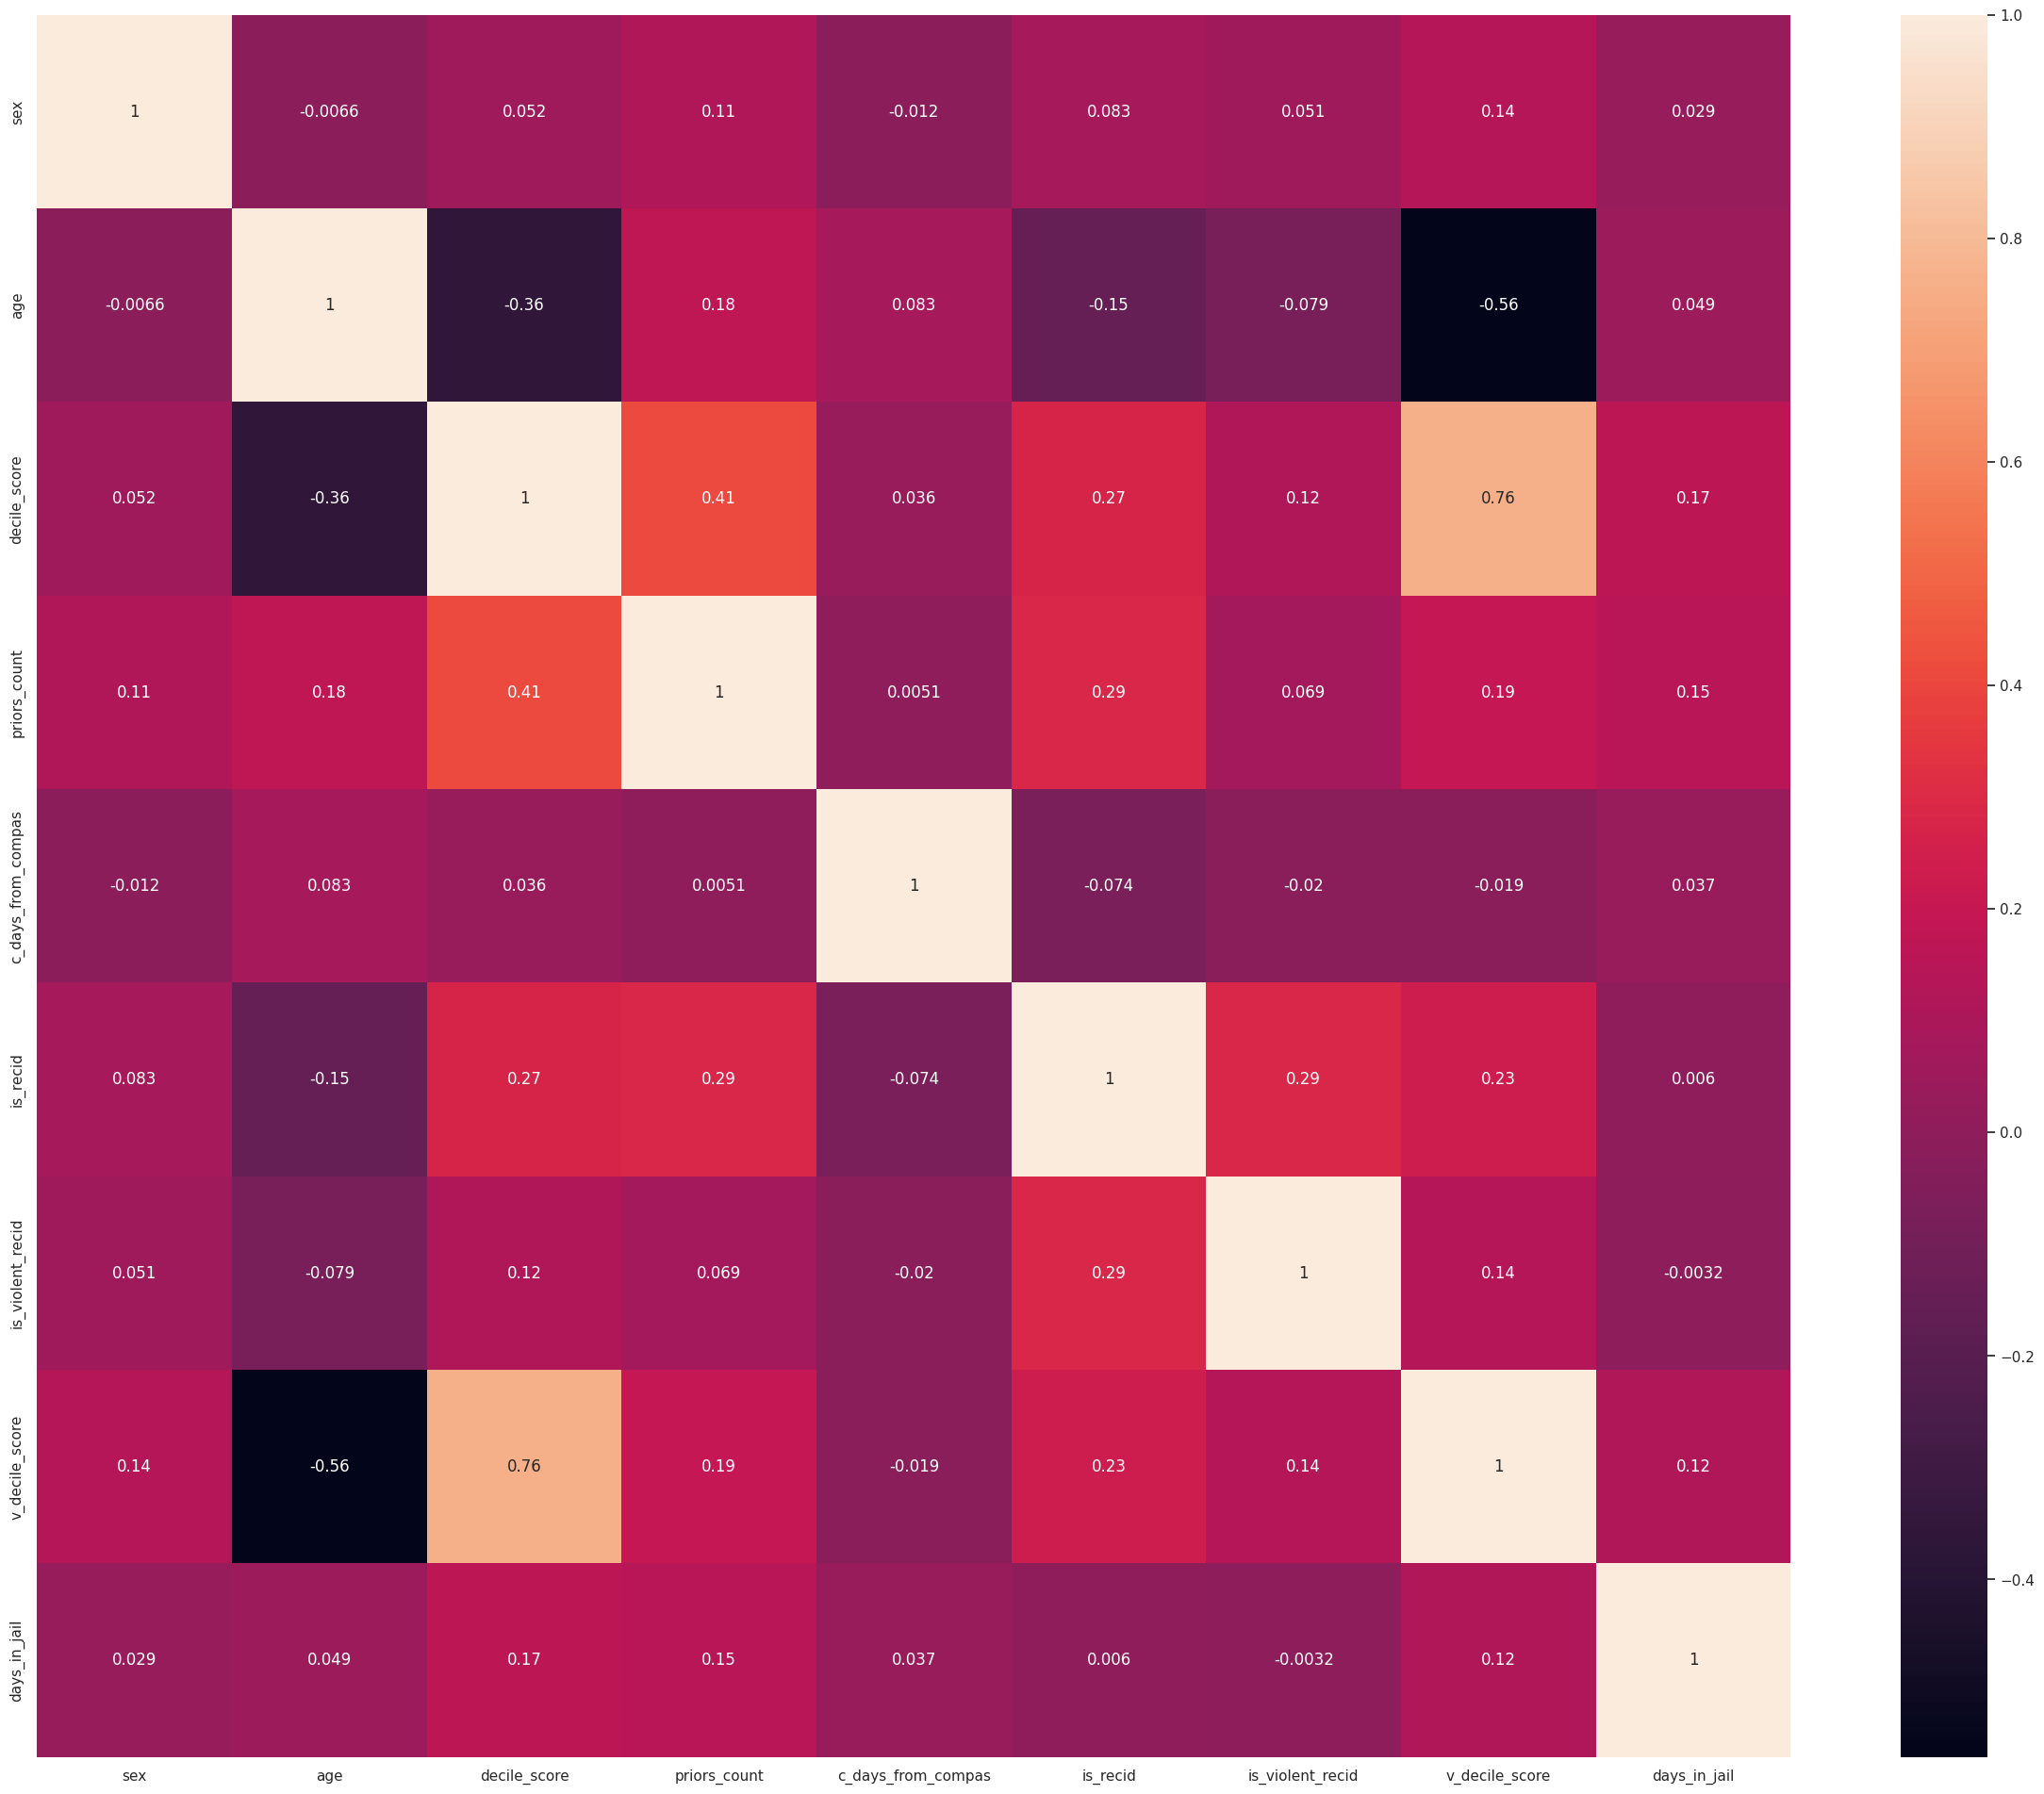

In [ ]:
plt.figure(figsize=(30, 24))
sns.heatmap(df.corr(), fmt='.2g', annot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

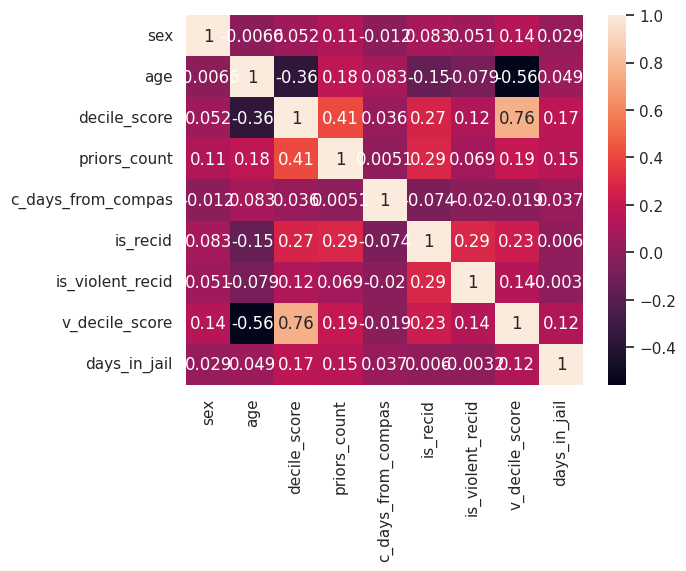

In [ ]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show

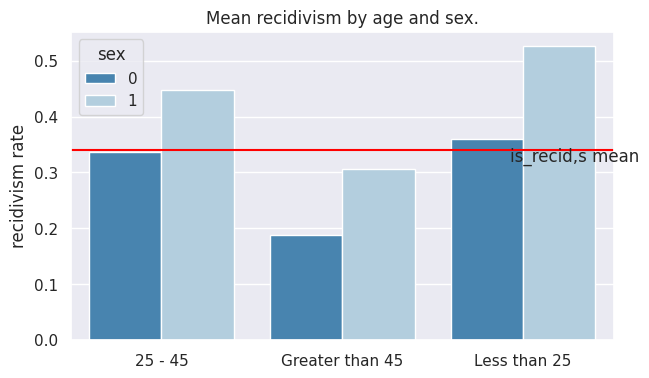

In [ ]:
df2 = df.groupby(["sex","age_cat"])["is_recid"].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=df2,x="age_cat",y="is_recid",hue="sex",palette="Blues_r")
plt.title("Mean recidivism by age and sex.")
plt.xlabel("")
plt.ylabel("recidivism rate")
plt.axhline(y=0.34,color="red")
plt.text(x=1.93,y=0.32,s="is_recid,s mean")

plt.show(block=False)

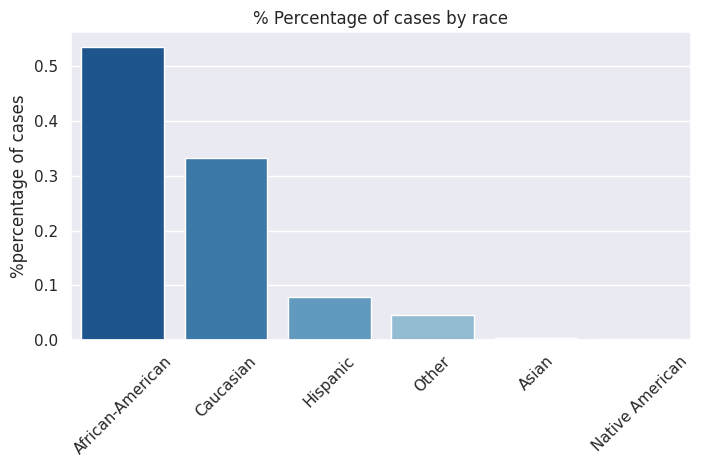

In [ ]:
df3 = df["race"].value_counts(normalize=True,ascending=False).reset_index()

plt.figure(figsize=(8,4))
sns.barplot(x=df3["index"],y=df3["race"],palette="Blues_r")
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("%percentage of cases")
plt.title("% Percentage of cases by race")
plt.show(block=False)

### Fairness

Fair representations:

- Avoiding Bias:

Evaluate the dataset for any inherent biases that may lead to unfair or discriminatory outcomes.
- Diversity and Inclusivity:

 Ensure that the dataset includes diverse samples that represent various demographic groups, such as age, gender, race, ethnicity, socioeconomic status, and other relevant factors. This helps to prevent biases and ensures that the model is not skewed towards any particular group.
- Transparency and Documentation:

Clearly document the data collection process, including details about the sampling methods, potential biases, and any other factors that may affect the dataset's representativeness. Transparency is crucial for understanding and addressing biases.
- Ethical Data Use:

Establish guidelines for ethical data use and ensure that the data is used in ways that align with ethical principles. This includes protecting individual privacy and avoiding discriminatory practices.

### Privacy

Data minimization is a privacy and data protection principle that emphasizes collecting, processing, and storing only the minimum amount of personal information necessary for a specific purpose.

- Purpose Limitation:

Data minimization starts with clearly defining the purpose for which the data is being collected. Only collect information that is directly relevant to the intended purpose and avoid gathering unnecessary details.

- Scope of Data:

Limit the types and categories of data collected to what is strictly required for the designated purpose. Avoid collecting extraneous or irrelevant information that does not contribute to the intended use.

- Data Retention:

Establish and adhere to clear guidelines regarding the retention of data. Only keep data for as long as it is necessary for the specified purpose. Once the data is no longer needed, it should be securely deleted or anonymized.

- Data Protection Impact Assessments (DPIAs):

Conduct DPIAs to assess and mitigate the risks associated with data processing activities. This includes evaluating the necessity and proportionality of data collection in relation to the potential impact on individuals.
